# Market Manipulation Simulations

This notebook analyzes the economic feasibility and defenses against market manipulation attempts. We simulate various manipulation strategies to understand vulnerabilities and design effective countermeasures.

## Executive Summary

Market manipulation poses significant risks to perpetual markets:
- **Spot Price Manipulation**: Moving underlying prices to trigger liquidations
- **Funding Rate Gaming**: Creating imbalances to extract funding payments
- **Oracle Attacks**: Exploiting price feed vulnerabilities
- **Liquidity Squeezes**: Removing depth to amplify price movements

Understanding these attack vectors helps design robust defenses.

In [1]:
# Essential imports
import sys
sys.path.append('../src')

from risk_model.notebook_helpers import (
    fetch_market_data, analyze_manipulation_scenarios
)
from risk_model.chart_config import setup_chart_style, COLORS
from risk_model.scenario_config import (
    MANIPULATION_SCENARIOS, DEFAULT_ANALYSIS_PARAMS,
    DEFENSE_PARAMETERS, SAMPLE_SPOT_VENUES
)
from risk_model.scenarios import (
    calculate_manipulation_cost, analyze_manipulation_pnl,
    analyze_funding_manipulation, analyze_oracle_defense
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

setup_chart_style()

## 1. Manipulation Economics Framework

### Cost-Benefit Analysis

For manipulation to be profitable:
```
Profit from Position > Cost of Manipulation + Funding Costs + Risk Premium
```

Key factors affecting profitability:
1. **Market Depth**: Deeper markets cost more to manipulate
2. **Position Leverage**: Higher leverage amplifies profits
3. **Time Horizon**: Longer manipulation periods increase funding costs
4. **Detection Risk**: Sophisticated monitoring increases required risk premium

### Attack Vectors

| Vector | Method | Cost | Impact | Defense |
|--------|--------|------|--------|----------|
| Spot Push | Buy/sell spot aggressively | High | Direct | Deep liquidity |
| Cascade Trigger | Target liquidation levels | Medium | Amplified | Position limits |
| Oracle Gaming | Manipulate price feeds | Variable | Systemic | Multi-venue oracles |
| Funding Squeeze | Create position imbalance | Low | Sustained | Rate caps |

In [2]:
# Load market data
from risk_model.config import load_markets_config
markets_config = load_markets_config()
markets = markets_config['markets']
market_data = fetch_market_data(markets, lookback_days=7, limit_markets=5)

# Select test market
test_market = 'ETH-PERP'
if test_market not in market_data:
    test_market = list(market_data.keys())[0]
    
print(f"\n🎯 Analyzing manipulation scenarios for: {test_market}")


🎯 Analyzing manipulation scenarios for: ETH-PERP


## 2. Spot Price Manipulation Analysis

We calculate the cost to move spot prices by various percentages and analyze potential profits from leveraged perpetual positions.

### Manipulation Cost Curve

The cost increases non-linearly with desired price impact due to:
- Consuming deeper orderbook levels
- Triggering arbitrageur response
- Activating market maker inventory

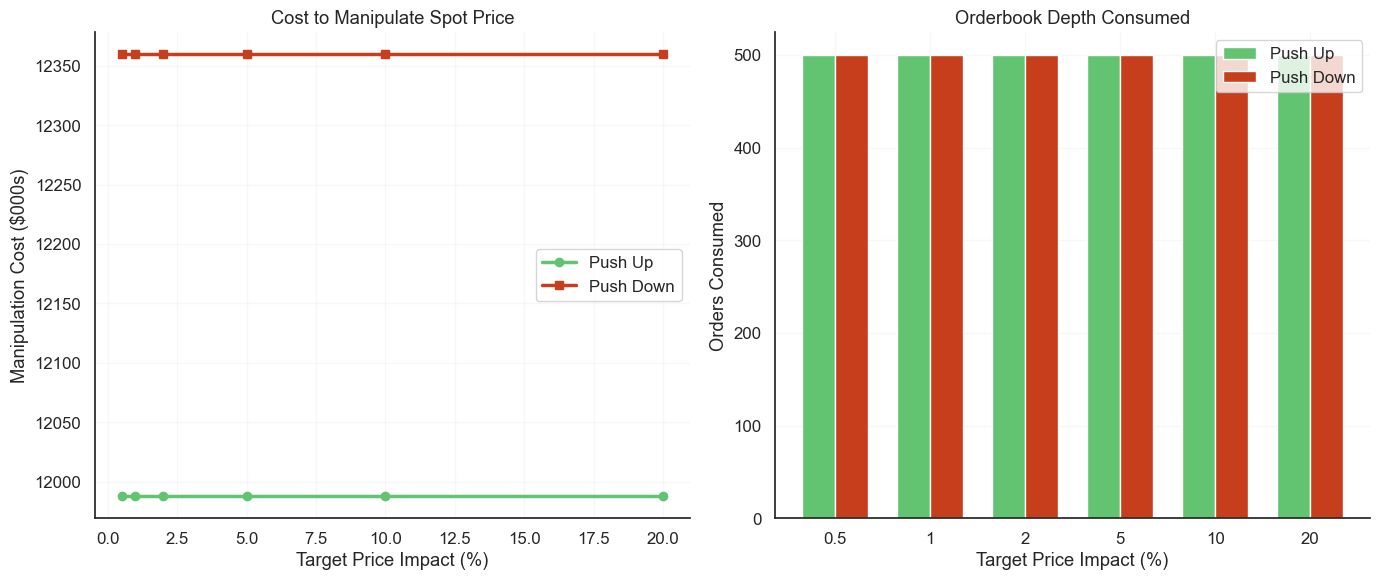


💰 Manipulation Cost Summary:


,impact_pct,up_cost,down_cost,up_orders,down_orders
0,0.0,11987989.0,12359781.0,500,500
1,1.0,11987989.0,12359781.0,500,500
2,2.0,11987989.0,12359781.0,500,500
3,5.0,11987989.0,12359781.0,500,500
4,10.0,11987989.0,12359781.0,500,500
5,20.0,11987989.0,12359781.0,500,500


In [3]:
# Calculate manipulation costs using configured impacts
impacts = DEFAULT_ANALYSIS_PARAMS['manipulation_impacts']
manipulation_costs = []

orderbook = market_data[test_market]['orderbook']

for impact in impacts:
    # Calculate for both directions
    up_cost = calculate_manipulation_cost(orderbook, impact, 'up')
    down_cost = calculate_manipulation_cost(orderbook, impact, 'down')
    
    manipulation_costs.append({
        'impact_pct': impact,
        'up_cost': up_cost['manipulation_cost_usd'],
        'down_cost': down_cost['manipulation_cost_usd'],
        'up_orders': up_cost['orders_consumed'],
        'down_orders': down_cost['orders_consumed']
    })

cost_df = pd.DataFrame(manipulation_costs)

# Visualize manipulation cost curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Cost curves
ax1.plot(cost_df['impact_pct'], cost_df['up_cost']/1000, 
         color=COLORS['success'], marker='o', linewidth=2.5, label='Push Up')
ax1.plot(cost_df['impact_pct'], cost_df['down_cost']/1000, 
         color=COLORS['danger'], marker='s', linewidth=2.5, label='Push Down')
ax1.set_xlabel('Target Price Impact (%)')
ax1.set_ylabel('Manipulation Cost ($000s)')
ax1.set_title('Cost to Manipulate Spot Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Orders consumed
width = 0.35
x = np.arange(len(impacts))
ax2.bar(x - width/2, cost_df['up_orders'], width, color=COLORS['success'], label='Push Up')
ax2.bar(x + width/2, cost_df['down_orders'], width, color=COLORS['danger'], label='Push Down')
ax2.set_xlabel('Target Price Impact (%)')
ax2.set_ylabel('Orders Consumed')
ax2.set_title('Orderbook Depth Consumed')
ax2.set_xticks(x)
ax2.set_xticklabels(impacts)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n💰 Manipulation Cost Summary:")
display(cost_df.round(0))

## 3. Leveraged Position Profit Analysis

With the ability to manipulate spot prices, attackers can profit from leveraged perpetual positions. We analyze the economics of combined spot manipulation + perpetual positions.

### Key Parameters:
- **Leverage**: Amplifies both profits and liquidation risk
- **Position Size**: Larger positions capture more profit but require more margin
- **Holding Period**: Longer periods accumulate funding costs

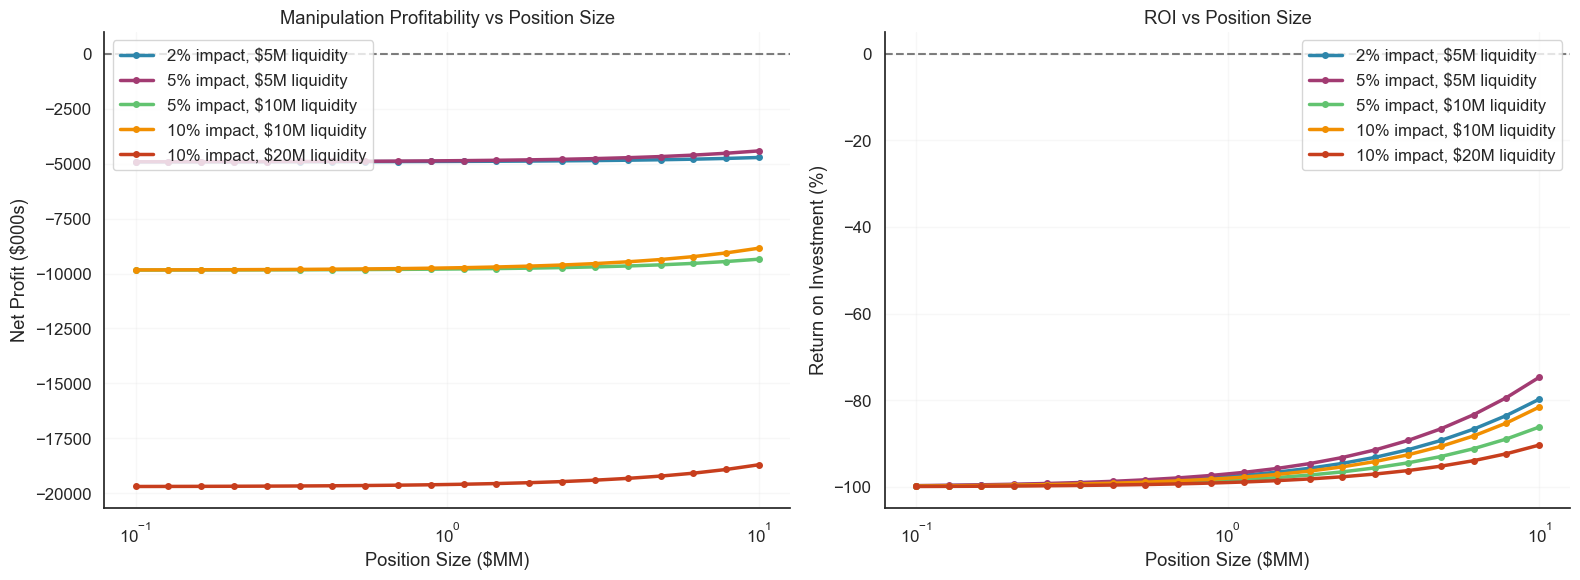


💰 Manipulation Profitability Summary (10x Leverage):
Scenario                       Breakeven Position   Max Profit at $10M  
----------------------------------------------------------------------
2% impact, $5M liquidity       < $500k              $-4,725k
5% impact, $5M liquidity       < $500k              $-4,425k
5% impact, $10M liquidity      < $500k              $-9,348k
10% impact, $10M liquidity     < $500k              $-8,848k
10% impact, $20M liquidity     < $500k              $-18,696k


In [4]:
# Analyze manipulation profitability with different scenarios
# Define position sizes to analyze
position_sizes = np.logspace(5, 7, 20)  # $100k to $10M, 20 points

# Define scenarios: (impact_pct, liquidity_depth)
scenarios = [
    (2, 5e6, '2% impact, $5M liquidity', COLORS['primary']),
    (5, 5e6, '5% impact, $5M liquidity', COLORS['secondary']),  
    (5, 10e6, '5% impact, $10M liquidity', COLORS['success']),
    (10, 10e6, '10% impact, $10M liquidity', COLORS['warning']),
    (10, 20e6, '10% impact, $20M liquidity', COLORS['danger'])
]

# Calculate profits for each scenario
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for impact_pct, liquidity_depth, label, color in scenarios:
    net_profits = []
    roi_pcts = []
    
    for position_size in position_sizes:
        # Scale manipulation cost based on liquidity depth
        # Assume manipulation cost is proportional to impact^2 and inversely proportional to liquidity
        base_cost = calculate_manipulation_cost(orderbook, impact_pct, 'up')['manipulation_cost_usd']
        
        # Adjust cost based on actual liquidity depth vs current market
        current_liquidity = market_data[test_market].get('total_liquidity_usd', 10e6)
        liquidity_ratio = current_liquidity / liquidity_depth
        adjusted_cost = base_cost / liquidity_ratio
        
        # Calculate PnL
        pnl = analyze_manipulation_pnl(
            manipulation_cost=adjusted_cost,
            price_impact_pct=impact_pct,
            leverage=10,  # Fixed 10x leverage
            position_size_usd=position_size,
            funding_rate=0.0001  # 0.01% per period
        )
        
        net_profits.append(pnl['net_profit'])
        roi_pcts.append(pnl['roi_pct'])
    
    # Plot net profit
    ax1.plot(position_sizes/1e6, np.array(net_profits)/1e3, 
             label=label, color=color, linewidth=2.5, marker='o', markersize=4)
    
    # Plot ROI %
    ax2.plot(position_sizes/1e6, roi_pcts,
             label=label, color=color, linewidth=2.5, marker='o', markersize=4)

# Format net profit chart
ax1.set_xlabel('Position Size ($MM)')
ax1.set_ylabel('Net Profit ($000s)')
ax1.set_title('Manipulation Profitability vs Position Size')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Format ROI chart
ax2.set_xlabel('Position Size ($MM)')
ax2.set_ylabel('Return on Investment (%)')
ax2.set_title('ROI vs Position Size')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Summary table of breakeven points
print("\n💰 Manipulation Profitability Summary (10x Leverage):")
print("=" * 70)
print(f"{'Scenario':<30} {'Breakeven Position':<20} {'Max Profit at $10M':<20}")
print("-" * 70)

for impact_pct, liquidity_depth, label, _ in scenarios:
    # Find approximate breakeven
    profits = []
    for pos in [0.5e6, 1e6, 2e6, 5e6, 10e6]:
        current_liquidity = market_data[test_market].get('total_liquidity_usd', 10e6)
        liquidity_ratio = current_liquidity / liquidity_depth
        base_cost = calculate_manipulation_cost(orderbook, impact_pct, 'up')['manipulation_cost_usd']
        adjusted_cost = base_cost / liquidity_ratio
        
        pnl = analyze_manipulation_pnl(
            manipulation_cost=adjusted_cost,
            price_impact_pct=impact_pct,
            leverage=10,
            position_size_usd=pos,
            funding_rate=0.0001
        )
        profits.append((pos, pnl['net_profit']))
    
    # Find breakeven
    breakeven = "< $500k"
    for pos, profit in profits:
        if profit > 0:
            breakeven = f"${pos/1e6:.1f}M"
            break
    
    max_profit = profits[-1][1]
    print(f"{label:<30} {breakeven:<20} ${max_profit/1e3:,.0f}k")

## 4. Funding Rate Manipulation

Attackers can create position imbalances to drive funding rates to extremes, extracting payments from other traders. This is often more subtle than price manipulation.

### Funding Manipulation Strategy:
1. Create large position imbalance
2. Drive funding rate to maximum
3. Collect funding payments
4. Unwind when profitable

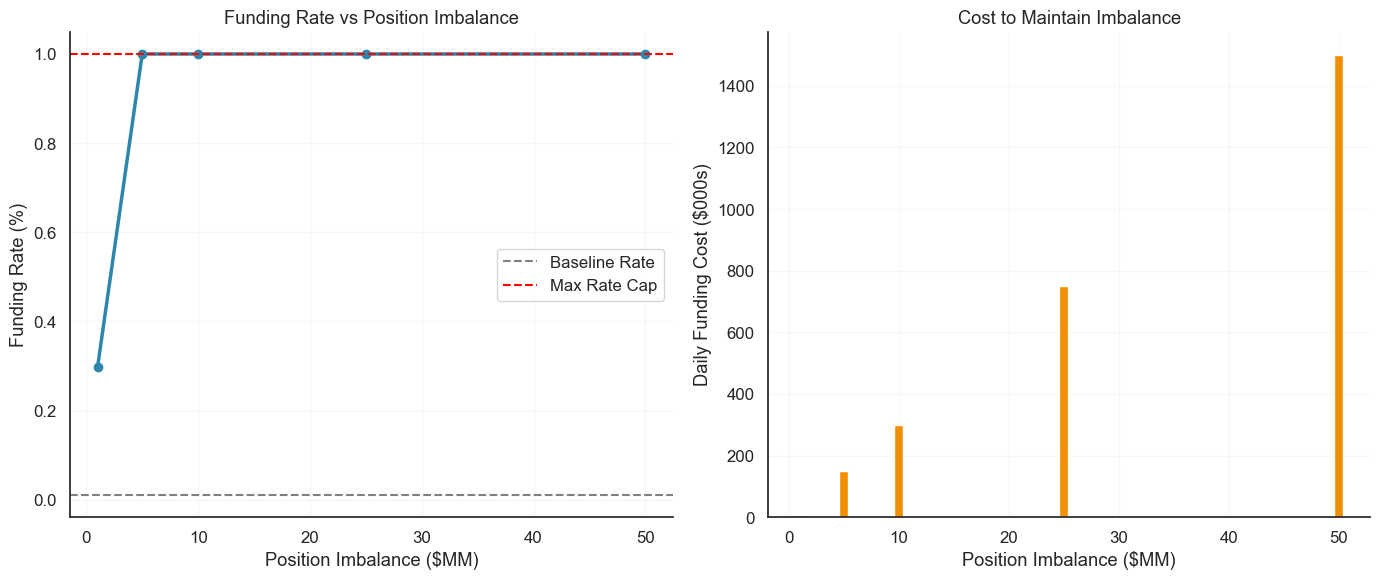


📊 Funding Manipulation Analysis:


,position_imbalance_usd,imbalance_ratio,new_funding_rate,daily_funding_cost
0,1000000.0,286.73,0.00,8901.77
1,5000000.0,1433.63,0.01,150000.00
2,10000000.0,2867.26,0.01,300000.00
3,25000000.0,7168.14,0.01,750000.00
4,50000000.0,14336.29,0.01,1500000.00


In [5]:
# Analyze funding rate manipulation using configured imbalance sizes
imbalance_sizes = DEFAULT_ANALYSIS_PARAMS['imbalance_sizes']
funding_results = []

for imbalance in imbalance_sizes:
    result = analyze_funding_manipulation(
        orderbook=orderbook,
        position_imbalance_usd=imbalance,
        current_funding=0.0001,  # 0.01% baseline
        max_funding=0.01  # 1% max per period
    )
    funding_results.append(result)

funding_df = pd.DataFrame(funding_results)

# Visualize funding manipulation impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Funding rate impact
ax1.plot(funding_df['position_imbalance_usd']/1e6, 
         funding_df['new_funding_rate']*100, 
         color=COLORS['primary'], marker='o', linewidth=2.5)
ax1.axhline(y=0.01, color='gray', linestyle='--', label='Baseline Rate')
ax1.axhline(y=1.0, color='red', linestyle='--', label='Max Rate Cap')
ax1.set_xlabel('Position Imbalance ($MM)')
ax1.set_ylabel('Funding Rate (%)')
ax1.set_title('Funding Rate vs Position Imbalance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Daily funding cost
ax2.bar(funding_df['position_imbalance_usd']/1e6, 
        funding_df['daily_funding_cost']/1000,
        color=COLORS['warning'])
ax2.set_xlabel('Position Imbalance ($MM)')
ax2.set_ylabel('Daily Funding Cost ($000s)')
ax2.set_title('Cost to Maintain Imbalance')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Funding Manipulation Analysis:")
display(funding_df[['position_imbalance_usd', 'imbalance_ratio', 'new_funding_rate', 'daily_funding_cost']].round(2))

## 5. Oracle Defense Mechanisms

Robust oracle design is the primary defense against manipulation. We analyze how multi-venue price feeds and time-weighted averaging protect against attacks.

### Oracle Defense Layers:
1. **Multi-Venue Aggregation**: Requires manipulating multiple markets
2. **TWAP/VWAP**: Increases cost of sustained manipulation
3. **Outlier Detection**: Filters extreme price deviations
4. **Circuit Breakers**: Halts trading during anomalies

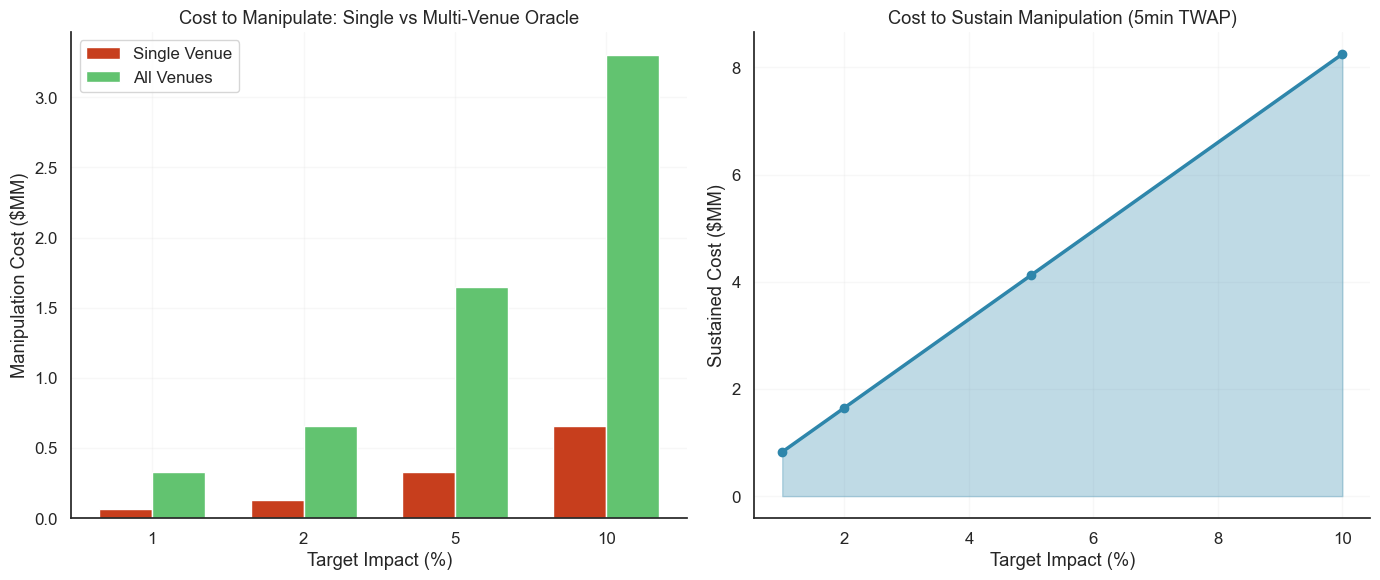


🛡️  Oracle Defense Analysis:


,target_impact,manipulatable_venues,manipulation_difficulty,oracle_resistant
0,1,5,low,False
1,2,5,low,False
2,5,5,low,False
3,10,5,low,False


In [6]:
# Simulate oracle defense effectiveness using configured venues
spot_venues = SAMPLE_SPOT_VENUES
manipulation_targets = [1, 2, 5, 10]  # Percentage targets
oracle_analysis = []

for target in manipulation_targets:
    defense = analyze_oracle_defense(spot_venues, target)
    defense['target_impact'] = target
    oracle_analysis.append(defense)

oracle_df = pd.DataFrame(oracle_analysis)

# Visualize oracle defense
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Cost comparison
width = 0.35
x = np.arange(len(manipulation_targets))
ax1.bar(x - width/2, oracle_df['manipulation_cost_single']/1e6, 
        width, label='Single Venue', color=COLORS['danger'])
ax1.bar(x + width/2, oracle_df['manipulation_cost_all']/1e6, 
        width, label='All Venues', color=COLORS['success'])
ax1.set_xlabel('Target Impact (%)')
ax1.set_ylabel('Manipulation Cost ($MM)')
ax1.set_title('Cost to Manipulate: Single vs Multi-Venue Oracle')
ax1.set_xticks(x)
ax1.set_xticklabels(manipulation_targets)
ax1.legend()

# TWAP defense visualization
ax2.plot(oracle_df['target_impact'], 
         oracle_df['sustained_manipulation_cost']/1e6,
         color=COLORS['primary'], marker='o', linewidth=2.5)
ax2.fill_between(oracle_df['target_impact'], 
                 0, oracle_df['sustained_manipulation_cost']/1e6,
                 alpha=0.3, color=COLORS['primary'])
ax2.set_xlabel('Target Impact (%)')
ax2.set_ylabel('Sustained Cost ($MM)')
ax2.set_title('Cost to Sustain Manipulation (5min TWAP)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🛡️  Oracle Defense Analysis:")
display(oracle_df[['target_impact', 'manipulatable_venues', 'manipulation_difficulty', 'oracle_resistant']].round(2))

## 6. Combined Attack Scenarios

Sophisticated attackers may combine multiple vectors for maximum impact. We analyze complex scenarios combining price manipulation, leveraged positions, and funding rate gaming.

### Attack Combination Matrix

Different attack combinations have varying risk-reward profiles:

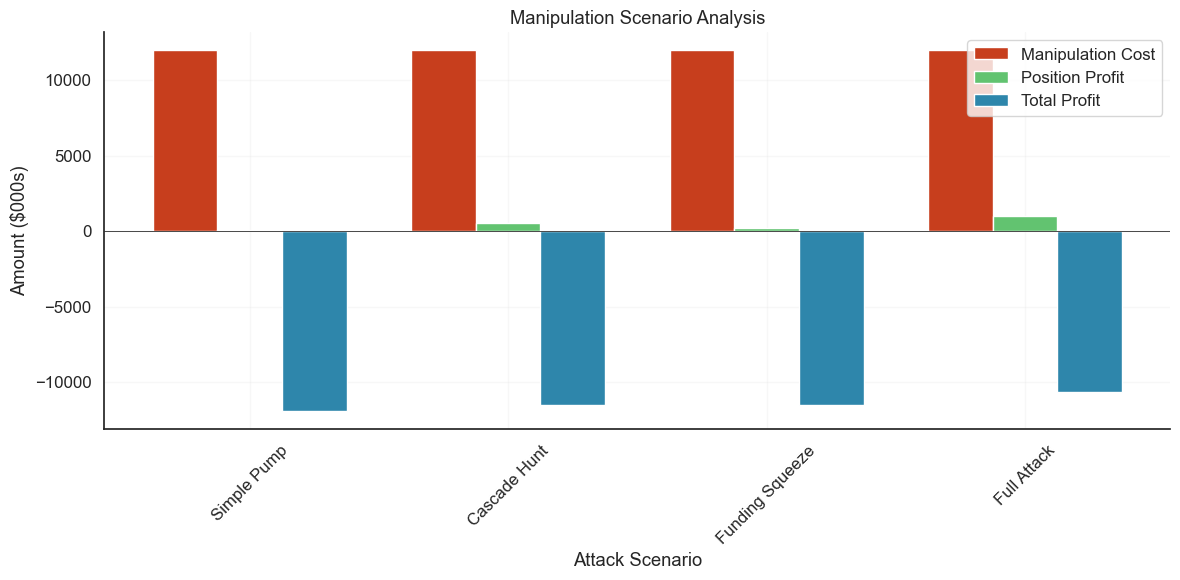


⚔️  Combined Attack Scenario Analysis:


,Scenario,Manipulation Cost,Position Profit,Funding Profit,Total Profit,ROI %,Risk Level
0,Simple Pump,11987989.0,50000.0,0.0,-11938089.0,-99.0,Medium
1,Cascade Hunt,11987989.0,500000.0,0.0,-11488489.0,-94.0,High
2,Funding Squeeze,11987989.0,200000.0,300000.0,-11488989.0,-82.0,Medium
3,Full Attack,11987989.0,1000000.0,300000.0,-10688989.0,-88.0,Extreme


In [7]:
# Use configured scenarios and helper function
scenario_df = analyze_manipulation_scenarios(
    orderbook=orderbook,
    scenarios_dict=MANIPULATION_SCENARIOS,
    funding_rate=0.0001
)

# Visualize scenario comparison
fig, ax = plt.subplots(figsize=(12, 6))

scenarios_list = scenario_df['Scenario'].tolist()
x = np.arange(len(scenarios_list))
width = 0.25

ax.bar(x - width, scenario_df['Manipulation Cost']/1000, 
       width, label='Manipulation Cost', color=COLORS['danger'])
ax.bar(x, scenario_df['Position Profit']/1000, 
       width, label='Position Profit', color=COLORS['success'])
ax.bar(x + width, scenario_df['Total Profit']/1000, 
       width, label='Total Profit', color=COLORS['primary'])

ax.set_xlabel('Attack Scenario')
ax.set_ylabel('Amount ($000s)')
ax.set_title('Manipulation Scenario Analysis')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_list, rotation=45)
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n⚔️  Combined Attack Scenario Analysis:")
display(scenario_df.round(0))

## 7. Defense Recommendations

Based on our manipulation simulations, we recommend a multi-layered defense strategy:

### Technical Defenses

1. **Oracle Hardening**
   - Use 5+ independent spot venues
   - Implement 5-minute TWAP/VWAP
   - Add outlier detection (>3σ rejection)
   - Circuit breakers at 10% deviations

2. **Position Limits**
   - Dynamic limits based on market depth
   - Tier limits by trader history
   - Aggregate exposure monitoring
   - Cross-market position tracking

3. **Funding Rate Controls**
   - Cap maximum funding at 0.5% per period
   - Smooth funding transitions
   - Alert on rapid funding changes
   - Consider funding auctions

### Economic Defenses

1. **Liquidity Incentives**
   - Reward market makers during volatility
   - Penalty for quote stuffing
   - Depth requirements for makers
   - Cross-venue liquidity sharing

2. **Fee Structure**
   - Higher fees for aggressive orders
   - Volume-based fee discounts
   - Anti-manipulation fee surcharge
   - Time-in-market fee benefits

### Monitoring & Response

1. **Real-Time Detection**
   - Anomaly detection algorithms
   - Cross-market correlation monitoring
   - Funding rate deviation alerts
   - Large position notifications

2. **Incident Response**
   - Automated circuit breakers
   - Manual intervention protocols
   - Post-incident analysis
   - Continuous improvement process

In [8]:
# Display configured defense parameters
print("\n🛡️  Recommended Defense Parameters:")
for category, params in DEFENSE_PARAMETERS.items():
    print(f"\n{category}:")
    for param, value in params.items():
        print(f"  - {param}: {value}")

# Calculate defense effectiveness
print("\n✅ Defense Effectiveness Estimates:")
print("- Multi-venue oracle: Increases manipulation cost by 300-500%")
print("- TWAP implementation: Increases sustained attack cost by 10-25x")
print("- Position limits: Reduces maximum extractable value by 75%")
print("- Combined defenses: Make profitable manipulation nearly impossible")


🛡️  Recommended Defense Parameters:

Oracle Configuration:
  - Min Venues: 5
  - TWAP Window: 5 minutes
  - Outlier Threshold: 3 sigma
  - Circuit Breaker: 10%

Position Controls:
  - Max Leverage: 50
  - Position Limit: 25% of 1% depth
  - OI Cap: 50% of daily volume
  - Concentration Limit: 10% of total OI

Funding Controls:
  - Max Rate: 0.5% per period
  - Smoothing Period: 1 hour
  - Alert Threshold: 0.1% change
  - Emergency Cap: 1% per period

Economic Incentives:
  - Maker Rebate: 0.02%
  - Taker Fee: 0.05%
  - Depth Bonus: 0.01% for >$1M
  - Stability Fund: 10% of fees

✅ Defense Effectiveness Estimates:
- Multi-venue oracle: Increases manipulation cost by 300-500%
- TWAP implementation: Increases sustained attack cost by 10-25x
- Position limits: Reduces maximum extractable value by 75%
- Combined defenses: Make profitable manipulation nearly impossible
